# Water Usage

Libraries and Functions

In [1]:
import os
import pandas as pd
import numpy as np
import collections
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_
  
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    

def to_sequences(seq_size, df ,data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = df[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        #window = [[x] for x in window]
       #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
  
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
 
  # Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


##### Selecting Data Files and making Dataframe

In [2]:
path=os.getcwd() #+ "\Data"
path
files=os.listdir(path)
files

['.ipynb_checkpoints',
 'cooling_detail_2014.xlsx',
 'cooling_detail_2015.xlsx',
 'cooling_detail_2016.xlsx',
 'cooling_detail_2017.xlsx',
 'Data',
 'Water Usage.ipynb',
 'weights']

In [3]:
files_xls = [f for f in files if f[-4:] == 'xlsx']
files_xls

['cooling_detail_2014.xlsx',
 'cooling_detail_2015.xlsx',
 'cooling_detail_2016.xlsx',
 'cooling_detail_2017.xlsx']

In [4]:
df_cooling_detail=pd.DataFrame()

for f in files_xls:
    data = pd.read_excel(f, sheet_name=0, header=0, usecols="C:F,M,P,S,AD,AE,AL,AO,BJ,BK", sort=False, encoding="utf-8")
    df_cooling_detail = df_cooling_detail.append(data)
#Reading data from excel
#df_cooling_detail = pd.read_excel('cooling_detail_2014.xlsx', sheet_name=0, header=0, , encoding="utf-8")
df_cooling_detail.shape

(331788, 13)

In [5]:
df_cooling_detail_backup = df_cooling_detail

In [6]:
df_cooling_detail[0:5]

,Plant Code,Plant Name,Year,Month,Net Generation from Steam Turbines (MWh),Net Generation Associated with Single Shaft Combined Cycle Units (MWh),Net Generation Associated with Combined Cycle Gas Turbines (MWh),Water Withdrawal Volume (Million Gallons),Water Consumption Volume (Million Gallons),860 Cooling Type 1,Cooling System Type,Generator Primary Energy Source Code,Generator Prime Mover Code
0,3,Barry,2014,1,13907,NaN,NaN,9583.79,0,(ON) Once through No Cool Pond,Open,BIT,ST
1,3,Barry,2014,2,-220,NaN,NaN,2062.2,0,(ON) Once through No Cool Pond,Open,BIT,ST
2,3,Barry,2014,3,-316,NaN,NaN,4515.46,0,(ON) Once through No Cool Pond,Open,BIT,ST
3,3,Barry,2014,4,-385,NaN,NaN,2409.9,0,(ON) Once through No Cool Pond,Open,BIT,ST
4,3,Barry,2014,5,-387,NaN,NaN,475.625,0,(ON) Once through No Cool Pond,Open,BIT,ST


In [7]:
# Displaying datatypes of all attributes
df_cooling_detail.dtypes

Plant Code                                                                 int64
Plant Name                                                                object
Year                                                                       int64
Month                                                                      int64
Net Generation from Steam Turbines (MWh)                                  object
Net Generation Associated with Single Shaft Combined Cycle Units (MWh)    object
Net Generation Associated with Combined Cycle Gas Turbines (MWh)          object
Water Withdrawal Volume (Million Gallons)                                 object
Water Consumption Volume (Million Gallons)                                object
860 Cooling Type 1                                                        object
Cooling System Type                                                       object
Generator Primary Energy Source Code                                      object
Generator Prime Mover Code  

In [8]:
df_cooling_detail.describe()

,Plant Code,Year,Month
count,331788.000000,331788.000000,331788.000000
mean,24584.735470,2015.499222,6.500000
std,24846.879103,1.118601,3.452058
min,3.000000,2014.000000,1.000000
25%,2723.000000,2014.000000,3.750000
50%,10017.000000,2015.000000,6.500000
75%,55187.000000,2017.000000,9.250000
max,60786.000000,2017.000000,12.000000


In [9]:
# Renaming attributes
df_cooling_detail.rename(columns={'Net Generation Associated with Single Shaft Combined Cycle Units (MWh)': 'Net_Generation_Single_Shaft', 
                                  'Net Generation from Steam Turbines (MWh)': 'Net_Generation_Stream_Turbines',
                                  'Net Generation Associated with Combined Cycle Gas Turbines (MWh)':'Net_Generation_Gas_Turbines',
                                  'Water Withdrawal Volume (Million Gallons)':'Water_Withdrawal_Volumn',
                                  'Water Consumption Volume (Million Gallons)':'Water_Consumption_Volume',
                                  'Generator Primary Energy Source Code':'Generator_Primary_Energy_Source_Code',
                                  'Generator Prime Mover Code':'Generator_Prime_Mover_Code',
                                  '860 Cooling Type 1':'Cooling_Type_860',                                  
                                  'Cooling System Type':'Cooling_System_Type',
                                  'Plant Name':'Plant_Name',
                                  'Plant Code':'Plant_Code'}, inplace=True);

In [10]:
# Changing datatype to numeric of selected attributes
df_cooling_detail['Net_Generation_Stream_Turbines'] = pd.to_numeric(df_cooling_detail['Net_Generation_Stream_Turbines'], errors='coerce')
df_cooling_detail['Net_Generation_Single_Shaft'] = pd.to_numeric(df_cooling_detail['Net_Generation_Single_Shaft'], errors='coerce')
df_cooling_detail['Net_Generation_Gas_Turbines'] = pd.to_numeric(df_cooling_detail['Net_Generation_Gas_Turbines'], errors='coerce')
df_cooling_detail['Water_Withdrawal_Volumn'] = pd.to_numeric(df_cooling_detail['Water_Withdrawal_Volumn'], errors='coerce')
df_cooling_detail['Water_Consumption_Volume'] = pd.to_numeric(df_cooling_detail['Water_Consumption_Volume'], errors='coerce')

In [11]:
# Verifying datatype change
df_cooling_detail.dtypes

Plant_Code                                int64
Plant_Name                               object
Year                                      int64
Month                                     int64
Net_Generation_Stream_Turbines          float64
Net_Generation_Single_Shaft             float64
Net_Generation_Gas_Turbines             float64
Water_Withdrawal_Volumn                 float64
Water_Consumption_Volume                float64
Cooling_Type_860                         object
Cooling_System_Type                      object
Generator_Primary_Energy_Source_Code     object
Generator_Prime_Mover_Code               object
dtype: object

#### Removing rows of Cooling System Type other than Open and Closed

In [12]:
df_cooling_detail=df_cooling_detail.loc[df_cooling_detail['Cooling_System_Type'].isin(['Open','Closed'])]
df_cooling_detail[0:5]

,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code
0,3,Barry,2014,1,13907.0,NaN,NaN,9583.791,0.0,(ON) Once through No Cool Pond,Open,BIT,ST
1,3,Barry,2014,2,-220.0,NaN,NaN,2062.200,0.0,(ON) Once through No Cool Pond,Open,BIT,ST
2,3,Barry,2014,3,-316.0,NaN,NaN,4515.460,0.0,(ON) Once through No Cool Pond,Open,BIT,ST
3,3,Barry,2014,4,-385.0,NaN,NaN,2409.900,0.0,(ON) Once through No Cool Pond,Open,BIT,ST
4,3,Barry,2014,5,-387.0,NaN,NaN,475.625,0.0,(ON) Once through No Cool Pond,Open,BIT,ST


In [13]:
# Verifying Cooling System Type values
df_cooling_detail.Cooling_System_Type.unique()

array(['Open', 'Closed'], dtype=object)

#### Removing rows where generation is null for whole year of an individual plant

In [14]:
# Groupby on Plant_Name and Year and aggregation of columns Net_Generation_Stream_Turbines, Net_Generation_Single_Shaft and Net_Generation_Gas_Turbines
new_df = df_cooling_detail.groupby(['Plant_Name','Year'], as_index=False).agg({'Net_Generation_Stream_Turbines': 'sum',
                                                               'Net_Generation_Single_Shaft': 'sum',
                                                               'Net_Generation_Gas_Turbines': 'sum'})

In [15]:
new_df[0:5]

,Plant_Name,Year,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines
0,A B Brown,2014,3046025.0,0.0,0.0
1,A B Brown,2015,2459453.0,0.0,0.0
2,A B Brown,2016,2110193.0,0.0,0.0
3,A B Brown,2017,1919347.0,0.0,0.0
4,ACE Cogeneration Facility,2014,331215.0,0.0,0.0


In [16]:
new_df.Net_Generation_Gas_Turbines.isnull().unique()

array([False])

In [17]:
# Rows with aggregation of all columns is 0
lst = new_df.loc[(new_df['Net_Generation_Stream_Turbines'] == 0) & (new_df['Net_Generation_Single_Shaft'] == 0) & (new_df['Net_Generation_Gas_Turbines'] == 0)]

In [18]:
lst

,Plant_Name,Year,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines
12,AES Beaver Valley Partners Beaver Valley,2014,0.0,0.0,0.0
13,AES Beaver Valley Partners Beaver Valley,2015,0.0,0.0,0.0
56,Alma,2015,0.0,0.0,0.0
57,Alma,2016,0.0,0.0,0.0
58,Alma,2017,0.0,0.0,0.0
78,Arapahoe,2014,0.0,0.0,0.0
79,Arapahoe,2015,0.0,0.0,0.0
80,Arapahoe,2016,0.0,0.0,0.0
81,Arapahoe,2017,0.0,0.0,0.0
86,ArcelorMittal Indiana Harbor West,2014,0.0,0.0,0.0


In [19]:
# Deleting rows with all values 0 
for i,row in lst.iterrows():
    df_cooling_detail=df_cooling_detail[~((df_cooling_detail['Plant_Name'] == row.Plant_Name) & 
                                          (df_cooling_detail['Year'] == row.Year))]

In [20]:
df_cooling_detail.shape

(229920, 13)

#### Assigning 0 to null generation values

In [24]:
df_cooling_detail[(df_cooling_detail['Net_Generation_Stream_Turbines'].isnull()) 
                  | (df_cooling_detail['Net_Generation_Single_Shaft'].isnull()) 
                  | (df_cooling_detail['Net_Generation_Gas_Turbines'].isnull())
                  #& (df_cooling_detail['Water_Withdrawal_Volumn'].isnull())
                  #& (df_cooling_detail['Water_Consumption_Volume'].isnull())
                 ].shape

(28953, 13)

In [22]:
print(df_cooling_detail.loc[df_cooling_detail['Water_Withdrawal_Volumn'].isnull()])

       Plant_Code             Plant_Name  Year  Month  \
60              3                  Barry  2014      1   
61              3                  Barry  2014      2   
62              3                  Barry  2014      3   
63              3                  Barry  2014      4   
64              3                  Barry  2014      5   
65              3                  Barry  2014      6   
66              3                  Barry  2014      7   
67              3                  Barry  2014      8   
68              3                  Barry  2014      9   
69              3                  Barry  2014     10   
70              3                  Barry  2014     11   
71              3                  Barry  2014     12   
72              3                  Barry  2014      1   
73              3                  Barry  2014      2   
74              3                  Barry  2014      3   
75              3                  Barry  2014      4   
76              3              

In [25]:
values = {'Net_Generation_Single_Shaft':0, 
          'Net_Generation_Stream_Turbines':0,
          'Net_Generation_Gas_Turbines':0}
          #'Water_Withdrawal_Volumn':0,
          #'Water_Consumption_Volume':0}
df_cooling_detail=df_cooling_detail.fillna(value=values)

In [28]:
df_cooling_detail[(df_cooling_detail['Net_Generation_Stream_Turbines'].isnull()) 
                  | (df_cooling_detail['Net_Generation_Single_Shaft'].isnull()) 
                  | (df_cooling_detail['Net_Generation_Gas_Turbines'].isnull())
                  #& (df_cooling_detail['Water_Withdrawal_Volumn'].isnull())
                  #& (df_cooling_detail['Water_Consumption_Volume'].isnull())
                 ].shape

(0, 13)

In [29]:
df_cooling_detail.Net_Generation_Single_Shaft.isnull().unique()

array([False])

In [30]:
df_cooling_detail[0:5]

,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code
0,3,Barry,2014,1,13907.0,0.0,0.0,9583.791,0.0,(ON) Once through No Cool Pond,Open,BIT,ST
1,3,Barry,2014,2,-220.0,0.0,0.0,2062.200,0.0,(ON) Once through No Cool Pond,Open,BIT,ST
2,3,Barry,2014,3,-316.0,0.0,0.0,4515.460,0.0,(ON) Once through No Cool Pond,Open,BIT,ST
3,3,Barry,2014,4,-385.0,0.0,0.0,2409.900,0.0,(ON) Once through No Cool Pond,Open,BIT,ST
4,3,Barry,2014,5,-387.0,0.0,0.0,475.625,0.0,(ON) Once through No Cool Pond,Open,BIT,ST


### If Generation=0 and Consumption=null Then Consumption=0

In [31]:
df_cooling_detail.loc[(df_cooling_detail['Net_Generation_Stream_Turbines'] == 0) 
                             & (df_cooling_detail['Net_Generation_Single_Shaft'] == 0) 
                             & (df_cooling_detail['Net_Generation_Gas_Turbines'] == 0)
                             & (df_cooling_detail['Water_Consumption_Volume'].isnull())]

,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code
516,50,Widows Creek,2014,7,0.0,0.0,0.0,27705.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
517,50,Widows Creek,2014,8,0.0,0.0,0.0,26242.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
518,50,Widows Creek,2014,9,0.0,0.0,0.0,23866.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
519,50,Widows Creek,2014,10,0.0,0.0,0.0,16589.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
520,50,Widows Creek,2014,11,0.0,0.0,0.0,16192.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
521,50,Widows Creek,2014,12,0.0,0.0,0.0,16859.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
522,50,Widows Creek,2014,7,0.0,0.0,0.0,27705.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
523,50,Widows Creek,2014,8,0.0,0.0,0.0,26242.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
524,50,Widows Creek,2014,9,0.0,0.0,0.0,23866.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
525,50,Widows Creek,2014,10,0.0,0.0,0.0,16589.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST


In [32]:
df_cooling_detail.loc[(df_cooling_detail['Net_Generation_Stream_Turbines'] == 0) 
                             & (df_cooling_detail['Net_Generation_Single_Shaft'] == 0) 
                             & (df_cooling_detail['Net_Generation_Gas_Turbines'] == 0)
                             & (df_cooling_detail['Water_Consumption_Volume'].isnull()), 'Water_Consumption_Volume'] = 0

In [33]:
df_cooling_detail.loc[(df_cooling_detail['Net_Generation_Stream_Turbines'] == 0) 
                             & (df_cooling_detail['Net_Generation_Single_Shaft'] == 0) 
                             & (df_cooling_detail['Net_Generation_Gas_Turbines'] == 0)
                             & (df_cooling_detail['Water_Consumption_Volume'].isnull())]

,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code


### If Withdrawal=null Then Withdrawal=Consumption

In [34]:
df_cooling_detail.loc[(df_cooling_detail['Water_Withdrawal_Volumn'].isnull())]

,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code
60,3,Barry,2014,1,0.0,0.0,0.0,NaN,69.75,(RI) Recirculate: Induced Draft,Closed,NG,CT
61,3,Barry,2014,2,0.0,0.0,0.0,NaN,65.24,(RI) Recirculate: Induced Draft,Closed,NG,CT
62,3,Barry,2014,3,0.0,0.0,0.0,NaN,67.89,(RI) Recirculate: Induced Draft,Closed,NG,CT
63,3,Barry,2014,4,0.0,0.0,0.0,NaN,69.00,(RI) Recirculate: Induced Draft,Closed,NG,CT
64,3,Barry,2014,5,0.0,0.0,97095.0,NaN,68.20,(RI) Recirculate: Induced Draft,Closed,NG,CT
65,3,Barry,2014,6,0.0,0.0,88884.0,NaN,68.40,(RI) Recirculate: Induced Draft,Closed,NG,CT
66,3,Barry,2014,7,0.0,0.0,101903.0,NaN,74.40,(RI) Recirculate: Induced Draft,Closed,NG,CT
67,3,Barry,2014,8,0.0,0.0,105335.0,NaN,78.43,(RI) Recirculate: Induced Draft,Closed,NG,CT
68,3,Barry,2014,9,0.0,0.0,98977.0,NaN,72.30,(RI) Recirculate: Induced Draft,Closed,NG,CT
69,3,Barry,2014,10,0.0,0.0,118514.0,NaN,78.12,(RI) Recirculate: Induced Draft,Closed,NG,CT


In [35]:
df_cooling_detail["Water_Withdrawal_Volumn"] = df_cooling_detail["Water_Withdrawal_Volumn"].fillna(df_cooling_detail["Water_Consumption_Volume"])

In [36]:
df_cooling_detail.loc[(df_cooling_detail['Water_Withdrawal_Volumn'].isnull())]

,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code
320,26,E C Gaston,2014,9,-1866.0,0.0,0.0,NaN,NaN,(RI) Recirculate: Induced Draft,Closed,BIT,ST
321,26,E C Gaston,2014,10,-1341.0,0.0,0.0,NaN,NaN,(RI) Recirculate: Induced Draft,Closed,BIT,ST
322,26,E C Gaston,2014,11,-3885.0,0.0,0.0,NaN,NaN,(RI) Recirculate: Induced Draft,Closed,BIT,ST
333,26,E C Gaston,2014,10,-534.0,0.0,0.0,NaN,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
345,26,E C Gaston,2014,10,-246.0,0.0,0.0,NaN,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
355,26,E C Gaston,2014,8,54585.0,0.0,0.0,NaN,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
358,26,E C Gaston,2014,11,29351.0,0.0,0.0,NaN,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
367,26,E C Gaston,2014,8,-581.0,0.0,0.0,NaN,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
370,26,E C Gaston,2014,11,-481.0,0.0,0.0,NaN,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
381,26,E C Gaston,2014,10,-211.0,0.0,0.0,NaN,NaN,(ON) Once through No Cool Pond,Open,BIT,ST


### If Withdrawal !=0 and consumption=null Then Consumption=0

In [37]:
df_cooling_detail.loc[(df_cooling_detail['Water_Withdrawal_Volumn'] !=0)
                      & ~(df_cooling_detail['Water_Withdrawal_Volumn'].isnull())
                      & (df_cooling_detail['Water_Consumption_Volume'].isnull())]

,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code
228,8,Gorgas,2014,1,422108.0,0.0,0.0,12783.060,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
229,8,Gorgas,2014,2,357775.0,0.0,0.0,11739.570,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
230,8,Gorgas,2014,3,459468.0,0.0,0.0,12997.380,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
231,8,Gorgas,2014,4,346827.0,0.0,0.0,10465.060,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
232,8,Gorgas,2014,5,447528.0,0.0,0.0,10149.350,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
233,8,Gorgas,2014,6,397292.0,0.0,0.0,10323.420,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
234,8,Gorgas,2014,7,465960.0,0.0,0.0,12997.380,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
235,8,Gorgas,2014,8,459116.0,0.0,0.0,12077.710,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
236,8,Gorgas,2014,9,363060.0,0.0,0.0,11571.350,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
237,8,Gorgas,2014,10,455910.0,0.0,0.0,11111.100,NaN,(ON) Once through No Cool Pond,Open,BIT,ST


In [38]:
df_cooling_detail.loc[(df_cooling_detail['Water_Withdrawal_Volumn'] !=0)
                      & ~(df_cooling_detail['Water_Withdrawal_Volumn'].isnull())
                      & (df_cooling_detail['Water_Consumption_Volume'].isnull()),'Water_Consumption_Volume'] = 0

In [39]:
df_cooling_detail.loc[(df_cooling_detail['Water_Withdrawal_Volumn'] !=0)
                      & ~(df_cooling_detail['Water_Withdrawal_Volumn'].isnull())
                      & (df_cooling_detail['Water_Consumption_Volume'].isnull())]

,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code


### If Generation != 0 and Withdrawal = null and Consumption= null Then delete

In [40]:
df_cooling_detail.loc[((df_cooling_detail['Net_Generation_Stream_Turbines'] != 0) 
                             | (df_cooling_detail['Net_Generation_Single_Shaft'] != 0) 
                             | (df_cooling_detail['Net_Generation_Gas_Turbines'] != 0))
                             & (df_cooling_detail['Water_Withdrawal_Volumn'].isnull())
                             & (df_cooling_detail['Water_Consumption_Volume'].isnull())]

,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code
320,26,E C Gaston,2014,9,-1866.0,0.0,0.0,NaN,NaN,(RI) Recirculate: Induced Draft,Closed,BIT,ST
321,26,E C Gaston,2014,10,-1341.0,0.0,0.0,NaN,NaN,(RI) Recirculate: Induced Draft,Closed,BIT,ST
322,26,E C Gaston,2014,11,-3885.0,0.0,0.0,NaN,NaN,(RI) Recirculate: Induced Draft,Closed,BIT,ST
333,26,E C Gaston,2014,10,-534.0,0.0,0.0,NaN,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
345,26,E C Gaston,2014,10,-246.0,0.0,0.0,NaN,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
355,26,E C Gaston,2014,8,54585.0,0.0,0.0,NaN,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
358,26,E C Gaston,2014,11,29351.0,0.0,0.0,NaN,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
367,26,E C Gaston,2014,8,-581.0,0.0,0.0,NaN,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
370,26,E C Gaston,2014,11,-481.0,0.0,0.0,NaN,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
381,26,E C Gaston,2014,10,-211.0,0.0,0.0,NaN,NaN,(ON) Once through No Cool Pond,Open,BIT,ST


In [41]:
df_cooling_detail=df_cooling_detail[~(((df_cooling_detail['Net_Generation_Stream_Turbines'] != 0) 
                             | (df_cooling_detail['Net_Generation_Single_Shaft'] != 0) 
                             | (df_cooling_detail['Net_Generation_Gas_Turbines'] != 0))
                             & (df_cooling_detail['Water_Withdrawal_Volumn'].isnull())
                             & (df_cooling_detail['Water_Consumption_Volume'].isnull()))]

In [42]:
df_cooling_detail.loc[((df_cooling_detail['Net_Generation_Stream_Turbines'] != 0) 
                             | (df_cooling_detail['Net_Generation_Single_Shaft'] != 0) 
                             | (df_cooling_detail['Net_Generation_Gas_Turbines'] != 0))
                             & (df_cooling_detail['Water_Withdrawal_Volumn'].isnull())
                             & (df_cooling_detail['Water_Consumption_Volume'].isnull())]

,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code


#### Removing rows where Water_withdrawal is 0 or Water_Consumption is null

In [46]:
df_cooling_detail.loc[df_cooling_detail.Water_Consumption_Volume.isnull()].shape

(275, 13)

In [47]:
# Rows to be removed
df_cooling_detail.loc[(df_cooling_detail['Water_Withdrawal_Volumn'].isnull())
                             | (df_cooling_detail['Water_Consumption_Volume'].isnull())]

,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code
242,8,Gorgas,2014,3,-518.0,0.0,0.0,0.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
243,8,Gorgas,2014,4,-443.0,0.0,0.0,0.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
244,8,Gorgas,2014,5,-416.0,0.0,0.0,0.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
247,8,Gorgas,2014,8,-478.0,0.0,0.0,0.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
248,8,Gorgas,2014,9,-463.0,0.0,0.0,0.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
249,8,Gorgas,2014,10,-441.0,0.0,0.0,0.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
251,8,Gorgas,2014,12,-296.0,0.0,0.0,0.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
254,8,Gorgas,2014,3,-607.0,0.0,0.0,0.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
255,8,Gorgas,2014,4,-567.0,0.0,0.0,0.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST
256,8,Gorgas,2014,5,-470.0,0.0,0.0,0.0,NaN,(ON) Once through No Cool Pond,Open,BIT,ST


In [48]:
# Removes rows
df_cooling_detail=df_cooling_detail[~((df_cooling_detail['Water_Withdrawal_Volumn'].isnull()) 
                     | (df_cooling_detail['Water_Consumption_Volume'].isnull()))]

In [49]:
# Verifying rows removed
df_cooling_detail.loc[(df_cooling_detail['Water_Withdrawal_Volumn'].isnull())
                             | (df_cooling_detail['Water_Consumption_Volume'].isnull())]

,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code


#### Checking nulls in attributes

In [50]:
df_cooling_detail.loc[(df_cooling_detail['Net_Generation_Stream_Turbines'].isnull())].shape

(0, 13)

In [51]:
df_cooling_detail.loc[(df_cooling_detail['Net_Generation_Single_Shaft'].isnull())].shape

(0, 13)

In [52]:
df_cooling_detail.loc[(df_cooling_detail['Net_Generation_Gas_Turbines'].isnull())].shape

(0, 13)

In [53]:
df_cooling_detail.loc[(df_cooling_detail['Water_Withdrawal_Volumn'].isnull())].shape

(0, 13)

In [54]:
df_cooling_detail.loc[(df_cooling_detail['Water_Consumption_Volume'].isnull())].shape

(0, 13)

In [55]:
df_cooling_detail.loc[(df_cooling_detail['Generator_Primary_Energy_Source_Code'].isnull())].shape

(48, 13)

In [56]:
df_cooling_detail.loc[(df_cooling_detail['Generator_Prime_Mover_Code'].isnull())].shape

(48, 13)

#### Removing rows where Generator_Primary_Energy_Source_Code or Generator_Prime_Mover_Code are null

In [57]:
# Removes rows
df_cooling_detail=df_cooling_detail[~((df_cooling_detail['Generator_Primary_Energy_Source_Code'].isnull()) 
                     | (df_cooling_detail['Generator_Prime_Mover_Code'].isnull()))]

In [58]:
# Verifying rows removed
df_cooling_detail.loc[(df_cooling_detail['Generator_Primary_Energy_Source_Code'].isnull()) | (df_cooling_detail['Generator_Prime_Mover_Code'].isnull())].shape

(0, 13)

### To CSV for visualization

In [61]:
df_cooling_detail.to_csv('pre_processed.csv', encoding='utf-8', index=False)

In [87]:
df1 = df_cooling_detail

In [90]:
# Checking rows where withdrawal is 0
df_cooling_detail.loc[(df_cooling_detail['Water_Withdrawal_Volumn']==0)].shape

(0, 13)

In [91]:
#Removing rows where withdrawal is 0
df_cooling_detail=df_cooling_detail[~(df_cooling_detail['Water_Withdrawal_Volumn']==0)]

### Feature Normalization - Water Withdrawal

In [92]:
# Feature normalization
encode_numeric_range(df_cooling_detail, 'Net_Generation_Stream_Turbines')
encode_numeric_range(df_cooling_detail, 'Net_Generation_Single_Shaft')
encode_numeric_range(df_cooling_detail, 'Net_Generation_Gas_Turbines')
#encode_numeric_range(df_cooling_detail, 'Water_Withdrawal_Volumn')
encode_numeric_range(df_cooling_detail, 'Water_Consumption_Volume')
df_cooling_detail[0:5]

,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code
0,3,Barry,2014,1,0.027919,0.001008,0.010906,9583.791,0.06295,(ON) Once through No Cool Pond,Open,BIT,ST
1,3,Barry,2014,2,0.014842,0.001008,0.010906,2062.200,0.06295,(ON) Once through No Cool Pond,Open,BIT,ST
2,3,Barry,2014,3,0.014753,0.001008,0.010906,4515.460,0.06295,(ON) Once through No Cool Pond,Open,BIT,ST
3,3,Barry,2014,4,0.014689,0.001008,0.010906,2409.900,0.06295,(ON) Once through No Cool Pond,Open,BIT,ST
4,3,Barry,2014,5,0.014687,0.001008,0.010906,475.625,0.06295,(ON) Once through No Cool Pond,Open,BIT,ST


### One Hot Encoding

In [93]:
len(df_cooling_detail['Generator_Primary_Energy_Source_Code'].unique())

21

In [94]:
len(df_cooling_detail['Generator_Prime_Mover_Code'].unique())

4

In [95]:
len(df_cooling_detail['Cooling_System_Type'].unique())

2

In [96]:
len(df_cooling_detail['Cooling_Type_860'].unique())

6

In [97]:
# One hot encoding on Generator_Prime_Mover_Code and Generator_Primary_Energy_Source_Code
encode_text_dummy(df_cooling_detail, 'Cooling_Type_860')
encode_text_dummy(df_cooling_detail, 'Cooling_System_Type')
encode_text_dummy(df_cooling_detail, 'Generator_Primary_Energy_Source_Code')
encode_text_dummy(df_cooling_detail, 'Generator_Prime_Mover_Code')

In [98]:
df_cooling_detail=df_cooling_detail.drop(['Plant_Name','Plant_Code','Year','Month'],axis=1)

In [99]:
df_cooling_detail[0:5]

,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860-(OC) Once through with Cool Pond,Cooling_Type_860-(ON) Once through No Cool Pond,Cooling_Type_860-(RC) Recirculate: Cooling Pond,Cooling_Type_860-(RF) Recirculate: Forced Draft,Cooling_Type_860-(RI) Recirculate: Induced Draft,...,Generator_Primary_Energy_Source_Code-SGP,Generator_Primary_Energy_Source_Code-SUB,Generator_Primary_Energy_Source_Code-TDF,Generator_Primary_Energy_Source_Code-WC,Generator_Primary_Energy_Source_Code-WDS,Generator_Primary_Energy_Source_Code-WH,Generator_Prime_Mover_Code-CA,Generator_Prime_Mover_Code-CS,Generator_Prime_Mover_Code-CT,Generator_Prime_Mover_Code-ST
0,0.027919,0.001008,0.010906,9583.791,0.06295,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.014842,0.001008,0.010906,2062.200,0.06295,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.014753,0.001008,0.010906,4515.460,0.06295,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.014689,0.001008,0.010906,2409.900,0.06295,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.014687,0.001008,0.010906,475.625,0.06295,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Tensorflow Regression Model

In [101]:
# to x and y using Water_Withdrawal_Volumn at y
x,y = to_xy(df_cooling_detail,"Water_Withdrawal_Volumn")

In [280]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
checkpointer = ModelCheckpoint(filepath=os.getcwd()+"\weights\best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    model = Sequential()

    model.add(Dense(400, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(200,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=10)

print('Training finished...Loading the best model')  
print()
model.load_weights(os.getcwd()+"\weights\best_weights.hdf5") # load weights from best model


0
Train on 119838 samples, validate on 39947 samples
Epoch 1/10
 - 24s - loss: 37259700.2753 - val_loss: 33162400.4802
Epoch 2/10
 - 23s - loss: 34750926.2070 - val_loss: 32737385.9225
Epoch 3/10
 - 22s - loss: 34223512.4486 - val_loss: 32692635.6433
Epoch 4/10
 - 20s - loss: 33651211.3505 - val_loss: 31671859.9930
Epoch 5/10
 - 21s - loss: 32796127.1316 - val_loss: 32202685.9435
Epoch 6/10
 - 21s - loss: 31984114.6264 - val_loss: 30314370.6662
Epoch 7/10
 - 20s - loss: 31204680.1360 - val_loss: 30333520.8717
Epoch 8/10
 - 20s - loss: 30344722.2711 - val_loss: 28948884.4518
Epoch 9/10
 - 21s - loss: 29701566.2963 - val_loss: 27762087.4588
Epoch 10/10
 - 20s - loss: 29137196.8290 - val_loss: 27927479.3403
1
Train on 119838 samples, validate on 39947 samples
Epoch 1/10
 - 22s - loss: 37158269.5796 - val_loss: 33669163.7543
Epoch 2/10
 - 21s - loss: 34707461.8951 - val_loss: 32749768.7086
Epoch 3/10
 - 22s - loss: 34353081.7127 - val_loss: 32474694.0662
Epoch 4/10
 - 21s - loss: 33922589.

OSError: Unable to open file (unable to open file: name = 'C:\Users\preey\Downloads\Master's Project\Project\weightsest_weights.hdf5', errno = 22, error message = 'Invalid argument', flags = 0, o_flags = 0)

In [224]:
model.load_weights("/weights/best_weights.hdf5") # load weights from best model

OSError: Unable to open file (unable to open file: name = '/weights/best_weights.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Shape: (39947, 1)
Final score (RMSE): 5336.83935546875
R2 score: 0.586618


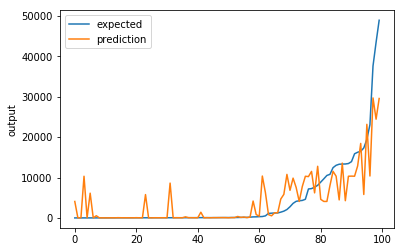

In [281]:
from sklearn.metrics import r2_score
pred = model.predict(x_test)
print("Shape: {}".format(pred.shape))
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))
print('R2 score: %2f' % r2_score(y_test,pred))
# Plot the chart
chart_regression(pred.flatten()[0:100],y_test[0:100])

In [282]:
# print out prediction
df_y = pd.DataFrame(y_test, columns=['ground_truth'])
df_pred = pd.DataFrame(pred, columns=['predicted'])
result = pd.concat([df_y, df_pred],axis=1)
result

,ground_truth,predicted
0,9681.349609,4082.317139
1,10791.733398,8037.872070
2,101.767998,83.343994
3,10.280000,25.103764
4,30.040001,31.371855
5,7262.080078,11515.276367
6,37627.601562,29714.617188
7,315.177002,438.964325
8,253.440002,4176.918945
9,43.000000,8624.043945


## Linear Regression

Coefficients: 
 [ 1.5607009e+04 -1.1017090e+02  3.7139187e+03 -7.2992104e+03
  3.3482484e+07  3.3485436e+07 -1.7005522e+07 -1.7017650e+07
 -1.7017838e+07 -1.7023580e+07  2.9895472e+07 -2.0598888e+07
 -2.7498525e+06 -2.7511618e+06 -2.7504575e+06 -2.7517345e+06
 -2.7531495e+06 -2.7474102e+06 -2.7493492e+06 -2.7529750e+06
 -2.7410330e+06 -2.7601138e+06 -2.7528448e+06 -2.7546510e+06
 -2.7497890e+06 -2.7495645e+06 -2.7553960e+06 -2.7589698e+06
 -2.7510940e+06 -2.7503128e+06 -2.7516792e+06 -2.7541005e+06
 -2.7524208e+06  2.8599060e+06  2.8603820e+06  2.8608160e+06
  2.8580240e+06]
Final score (RMSE): 6179.70654296875
Variance score: 0.45


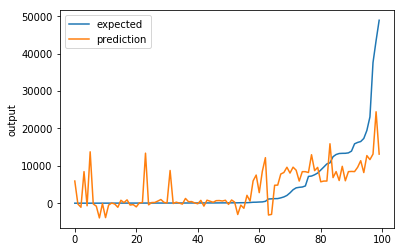

In [283]:
#Linear Regression
from sklearn import datasets, linear_model

#XTrain, XTest, YTrain, YTest = train_test_split(x, y, test_size=0.2, random_state=42)
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
liReg_pred = regr.predict(x_test)

print('Coefficients: \n', regr.coef_)
score = np.sqrt(metrics.mean_squared_error(liReg_pred,y_test))
print("Final score (RMSE): {}".format(score))
print('Variance score: %.2f' % r2_score(y_test, liReg_pred))
# Plot the chart
chart_regression(liReg_pred.flatten()[0:100],y_test[0:100])

In [284]:
# print out prediction
df_y = pd.DataFrame(y_test, columns=['ground_truth'])
df_pred = pd.DataFrame(liReg_pred, columns=['predicted'])
result = pd.concat([df_y, df_pred],axis=1)
result

,ground_truth,predicted
0,9681.349609,5924.0
1,10791.733398,15906.0
2,101.767998,286.0
3,10.280000,-88.0
4,30.040001,-366.0
5,7262.080078,12970.0
6,37627.601562,13141.0
7,315.177002,2826.0
8,253.440002,5964.0
9,43.000000,8752.0


## CNN

In [106]:
x = x.reshape((x.shape[0], 1, x.shape[1], 1))

# output labels should be one-hot vectors - ie,
# 0 -> [0, 0, 1]
# 1 -> [0, 1, 0]
# 2 -> [1, 0, 0]
# this operation changes the shape of y from (10000,1) to (10000, 3)

y_one_hot = keras.utils.to_categorical(y, 3)
#x.shape[1]

37

In [102]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [103]:
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (119838, 37)
Shape of y_train: (119838,)

Shape of x_test: (39947, 37)
Shape of y_test: (39947,)


## Feature Normalization - Water Consumption

In [293]:
df_cooling_detail = df1

In [294]:
df_cooling_detail[0:5]

,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code
0,3,Barry,2014,1,13907.0,0.0,0.0,9583.791,0.0,(ON) Once through No Cool Pond,Open,BIT,ST
1,3,Barry,2014,2,-220.0,0.0,0.0,2062.200,0.0,(ON) Once through No Cool Pond,Open,BIT,ST
2,3,Barry,2014,3,-316.0,0.0,0.0,4515.460,0.0,(ON) Once through No Cool Pond,Open,BIT,ST
3,3,Barry,2014,4,-385.0,0.0,0.0,2409.900,0.0,(ON) Once through No Cool Pond,Open,BIT,ST
4,3,Barry,2014,5,-387.0,0.0,0.0,475.625,0.0,(ON) Once through No Cool Pond,Open,BIT,ST


In [295]:
# Checking rows where withdrawal is 0
df_cooling_detail.loc[(df_cooling_detail['Water_Consumption_Volume']==0)].shape

(74987, 13)

In [296]:
#Removing rows where withdrawal is 0
df_cooling_detail=df_cooling_detail[~(df_cooling_detail['Water_Consumption_Volume']==0)]

In [297]:
# Feature normalization
encode_numeric_range(df_cooling_detail, 'Net_Generation_Stream_Turbines')
encode_numeric_range(df_cooling_detail, 'Net_Generation_Single_Shaft')
encode_numeric_range(df_cooling_detail, 'Net_Generation_Gas_Turbines')
encode_numeric_range(df_cooling_detail, 'Water_Withdrawal_Volumn')
#encode_numeric_range(df_cooling_detail, 'Water_Consumption_Volume')
df_cooling_detail[0:5]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Plant_Code,Plant_Name,Year,Month,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860,Cooling_System_Type,Generator_Primary_Energy_Source_Code,Generator_Prime_Mover_Code
36,3,Barry,2014,1,0.132616,0.000908,0.010906,0.126295,308.14,(ON) Once through No Cool Pond,Open,BIT,ST
37,3,Barry,2014,2,0.187795,0.000908,0.010906,0.065690,44.52,(ON) Once through No Cool Pond,Open,BIT,ST
38,3,Barry,2014,3,0.141970,0.000908,0.010906,0.048260,323.33,(ON) Once through No Cool Pond,Open,BIT,ST
40,3,Barry,2014,5,0.181243,0.000908,0.010906,0.144580,210.80,(ON) Once through No Cool Pond,Open,BIT,ST
41,3,Barry,2014,6,0.173855,0.000908,0.010906,0.140147,372.30,(ON) Once through No Cool Pond,Open,BIT,ST


### One Hot Encoding

In [298]:
len(df_cooling_detail['Generator_Primary_Energy_Source_Code'].unique())

20

In [299]:
len(df_cooling_detail['Generator_Prime_Mover_Code'].unique())

4

In [300]:
len(df_cooling_detail['Cooling_System_Type'].unique())

2

In [301]:
len(df_cooling_detail['Cooling_Type_860'].unique())

6

In [302]:
# One hot encoding on Generator_Prime_Mover_Code and Generator_Primary_Energy_Source_Code
encode_text_dummy(df_cooling_detail, 'Cooling_Type_860')
encode_text_dummy(df_cooling_detail, 'Cooling_System_Type')
encode_text_dummy(df_cooling_detail, 'Generator_Primary_Energy_Source_Code')
encode_text_dummy(df_cooling_detail, 'Generator_Prime_Mover_Code')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [303]:
df_cooling_detail=df_cooling_detail.drop(['Plant_Name','Plant_Code','Year','Month'],axis=1)

In [304]:
df_cooling_detail[0:5]

,Net_Generation_Stream_Turbines,Net_Generation_Single_Shaft,Net_Generation_Gas_Turbines,Water_Withdrawal_Volumn,Water_Consumption_Volume,Cooling_Type_860-(OC) Once through with Cool Pond,Cooling_Type_860-(ON) Once through No Cool Pond,Cooling_Type_860-(RC) Recirculate: Cooling Pond,Cooling_Type_860-(RF) Recirculate: Forced Draft,Cooling_Type_860-(RI) Recirculate: Induced Draft,...,Generator_Primary_Energy_Source_Code-SGC,Generator_Primary_Energy_Source_Code-SUB,Generator_Primary_Energy_Source_Code-TDF,Generator_Primary_Energy_Source_Code-WC,Generator_Primary_Energy_Source_Code-WDS,Generator_Primary_Energy_Source_Code-WH,Generator_Prime_Mover_Code-CA,Generator_Prime_Mover_Code-CS,Generator_Prime_Mover_Code-CT,Generator_Prime_Mover_Code-ST
36,0.132616,0.000908,0.010906,0.126295,308.14,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
37,0.187795,0.000908,0.010906,0.065690,44.52,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
38,0.141970,0.000908,0.010906,0.048260,323.33,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
40,0.181243,0.000908,0.010906,0.144580,210.80,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
41,0.173855,0.000908,0.010906,0.140147,372.30,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Tensorflow Regression Model

In [305]:
# to x and y using Water_Withdrawal_Volumn at y
x,y = to_xy(df_cooling_detail,"Water_Consumption_Volume")

In [306]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
checkpointer = ModelCheckpoint(filepath=os.getcwd()+"\weights\best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    model = Sequential()

    model.add(Dense(400, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(200,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=10)

print('Training finished...Loading the best model')  
print()
model.load_weights(os.getcwd()+"\weights\best_weights.hdf5") # load weights from best model


0
Train on 88066 samples, validate on 29356 samples
Epoch 1/10
 - 18s - loss: 12394.5240 - val_loss: 11759.0291
Epoch 2/10
 - 18s - loss: 11110.6897 - val_loss: 10298.5581
Epoch 3/10
 - 18s - loss: 10608.3162 - val_loss: 10103.2348
Epoch 4/10
 - 17s - loss: 10563.6274 - val_loss: 9692.4738
Epoch 5/10
 - 17s - loss: 10467.3450 - val_loss: 9501.4688
Epoch 6/10
 - 17s - loss: 10278.4873 - val_loss: 9644.3115
Epoch 7/10
 - 17s - loss: 10317.3204 - val_loss: 9336.0511
Epoch 8/10
 - 17s - loss: 10294.5951 - val_loss: 9673.7652
Epoch 9/10
 - 17s - loss: 10192.3818 - val_loss: 9370.0117
Epoch 10/10
 - 17s - loss: 10065.0428 - val_loss: 10475.8724
1
Train on 88066 samples, validate on 29356 samples
Epoch 1/10
 - 19s - loss: 12447.9752 - val_loss: 10935.8852
Epoch 2/10
 - 18s - loss: 10904.4957 - val_loss: 10459.4612
Epoch 3/10
 - 17s - loss: 10839.9323 - val_loss: 10052.7720
Epoch 4/10
 - 17s - loss: 10707.5796 - val_loss: 10075.6937
Epoch 5/10
 - 17s - loss: 10501.7035 - val_loss: 10195.3225
E

OSError: Unable to open file (unable to open file: name = 'C:\Users\preey\Downloads\Master's Project\Project\weightsest_weights.hdf5', errno = 22, error message = 'Invalid argument', flags = 0, o_flags = 0)

In [224]:
model.load_weights("/weights/best_weights.hdf5") # load weights from best model

OSError: Unable to open file (unable to open file: name = '/weights/best_weights.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Shape: (29356, 1)
Final score (RMSE): 107.8011474609375
R2 score: 0.435399


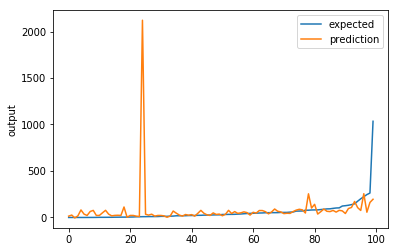

In [307]:
from sklearn.metrics import r2_score
pred = model.predict(x_test)
print("Shape: {}".format(pred.shape))
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))
print('R2 score: %2f' % r2_score(y_test,pred))
# Plot the chart
chart_regression(pred.flatten()[0:100],y_test[0:100])

In [314]:
# print out prediction
df_y = pd.DataFrame(y_test, columns=['ground_truth'])
#df_y = pd.DataFrame(y)
df_pred = pd.DataFrame(pred, columns=['predicted'])
result = pd.concat([df_y, df_pred],axis=1)
#result = pd.concat([x_test, result],axis=1)
result

,ground_truth,predicted
0,2.052000,17.523832
1,28.294001,36.426395
2,0.049000,17.335957
3,47.856998,74.667519
4,14.911000,69.051216
5,78.120003,254.537186
6,21.042000,30.609072
7,5.151000,21.709814
8,33.123001,76.635162
9,36.080002,44.124828


#### Linear Regression

Coefficients: 
 [ 1.5607009e+04 -1.1017090e+02  3.7139187e+03 -7.2992104e+03
  3.3482484e+07  3.3485436e+07 -1.7005522e+07 -1.7017650e+07
 -1.7017838e+07 -1.7023580e+07  2.9895472e+07 -2.0598888e+07
 -2.7498525e+06 -2.7511618e+06 -2.7504575e+06 -2.7517345e+06
 -2.7531495e+06 -2.7474102e+06 -2.7493492e+06 -2.7529750e+06
 -2.7410330e+06 -2.7601138e+06 -2.7528448e+06 -2.7546510e+06
 -2.7497890e+06 -2.7495645e+06 -2.7553960e+06 -2.7589698e+06
 -2.7510940e+06 -2.7503128e+06 -2.7516792e+06 -2.7541005e+06
 -2.7524208e+06  2.8599060e+06  2.8603820e+06  2.8608160e+06
  2.8580240e+06]
Final score (RMSE): 6179.70654296875
Variance score: 0.45


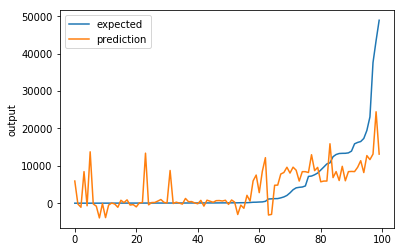

In [283]:
#Linear Regression
from sklearn import datasets, linear_model

#XTrain, XTest, YTrain, YTest = train_test_split(x, y, test_size=0.2, random_state=42)
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)
liReg_pred = regr.predict(x_test)

print('Coefficients: \n', regr.coef_)
score = np.sqrt(metrics.mean_squared_error(liReg_pred,y_test))
print("Final score (RMSE): {}".format(score))
print('Variance score: %.2f' % r2_score(y_test, liReg_pred))
# Plot the chart
chart_regression(liReg_pred.flatten()[0:100],y_test[0:100])

In [284]:
# print out prediction
df_y = pd.DataFrame(y_test, columns=['ground_truth'])
df_pred = pd.DataFrame(liReg_pred, columns=['predicted'])
result = pd.concat([df_y, df_pred],axis=1)
result

,ground_truth,predicted
0,9681.349609,5924.0
1,10791.733398,15906.0
2,101.767998,286.0
3,10.280000,-88.0
4,30.040001,-366.0
5,7262.080078,12970.0
6,37627.601562,13141.0
7,315.177002,2826.0
8,253.440002,5964.0
9,43.000000,8752.0
